<a href="https://colab.research.google.com/github/Pathway2008/Loan_rating/blob/main/2_level_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import pandas as pd
import numpy as np
train = pd.read_csv('/content/drive/MyDrive/loan_rating/train.csv')
test = pd.read_csv('/content/drive/MyDrive/loan_rating/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/loan_rating/sample_submission.csv')

In [7]:
import warnings
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
warnings.filterwarnings('ignore')
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [81]:
train = train[train['주택소유상태'] != 'ANY']
train['근로기간'] = train['근로기간'].replace('< 1 year', '<1 year')
train['근로기간'] = train['근로기간'].replace('1 year', '1 years')
train['근로기간'] = train['근로기간'].replace('3', '3 years')
train['근로기간'] = train['근로기간'].replace('10+years', '10+ years')

In [5]:
train.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


In [6]:
train_0 = train[train['최근_2년간_연체_횟수']==0].reset_index(drop=True)
train_1 = train[train['최근_2년간_연체_횟수']>0].reset_index(drop=True)

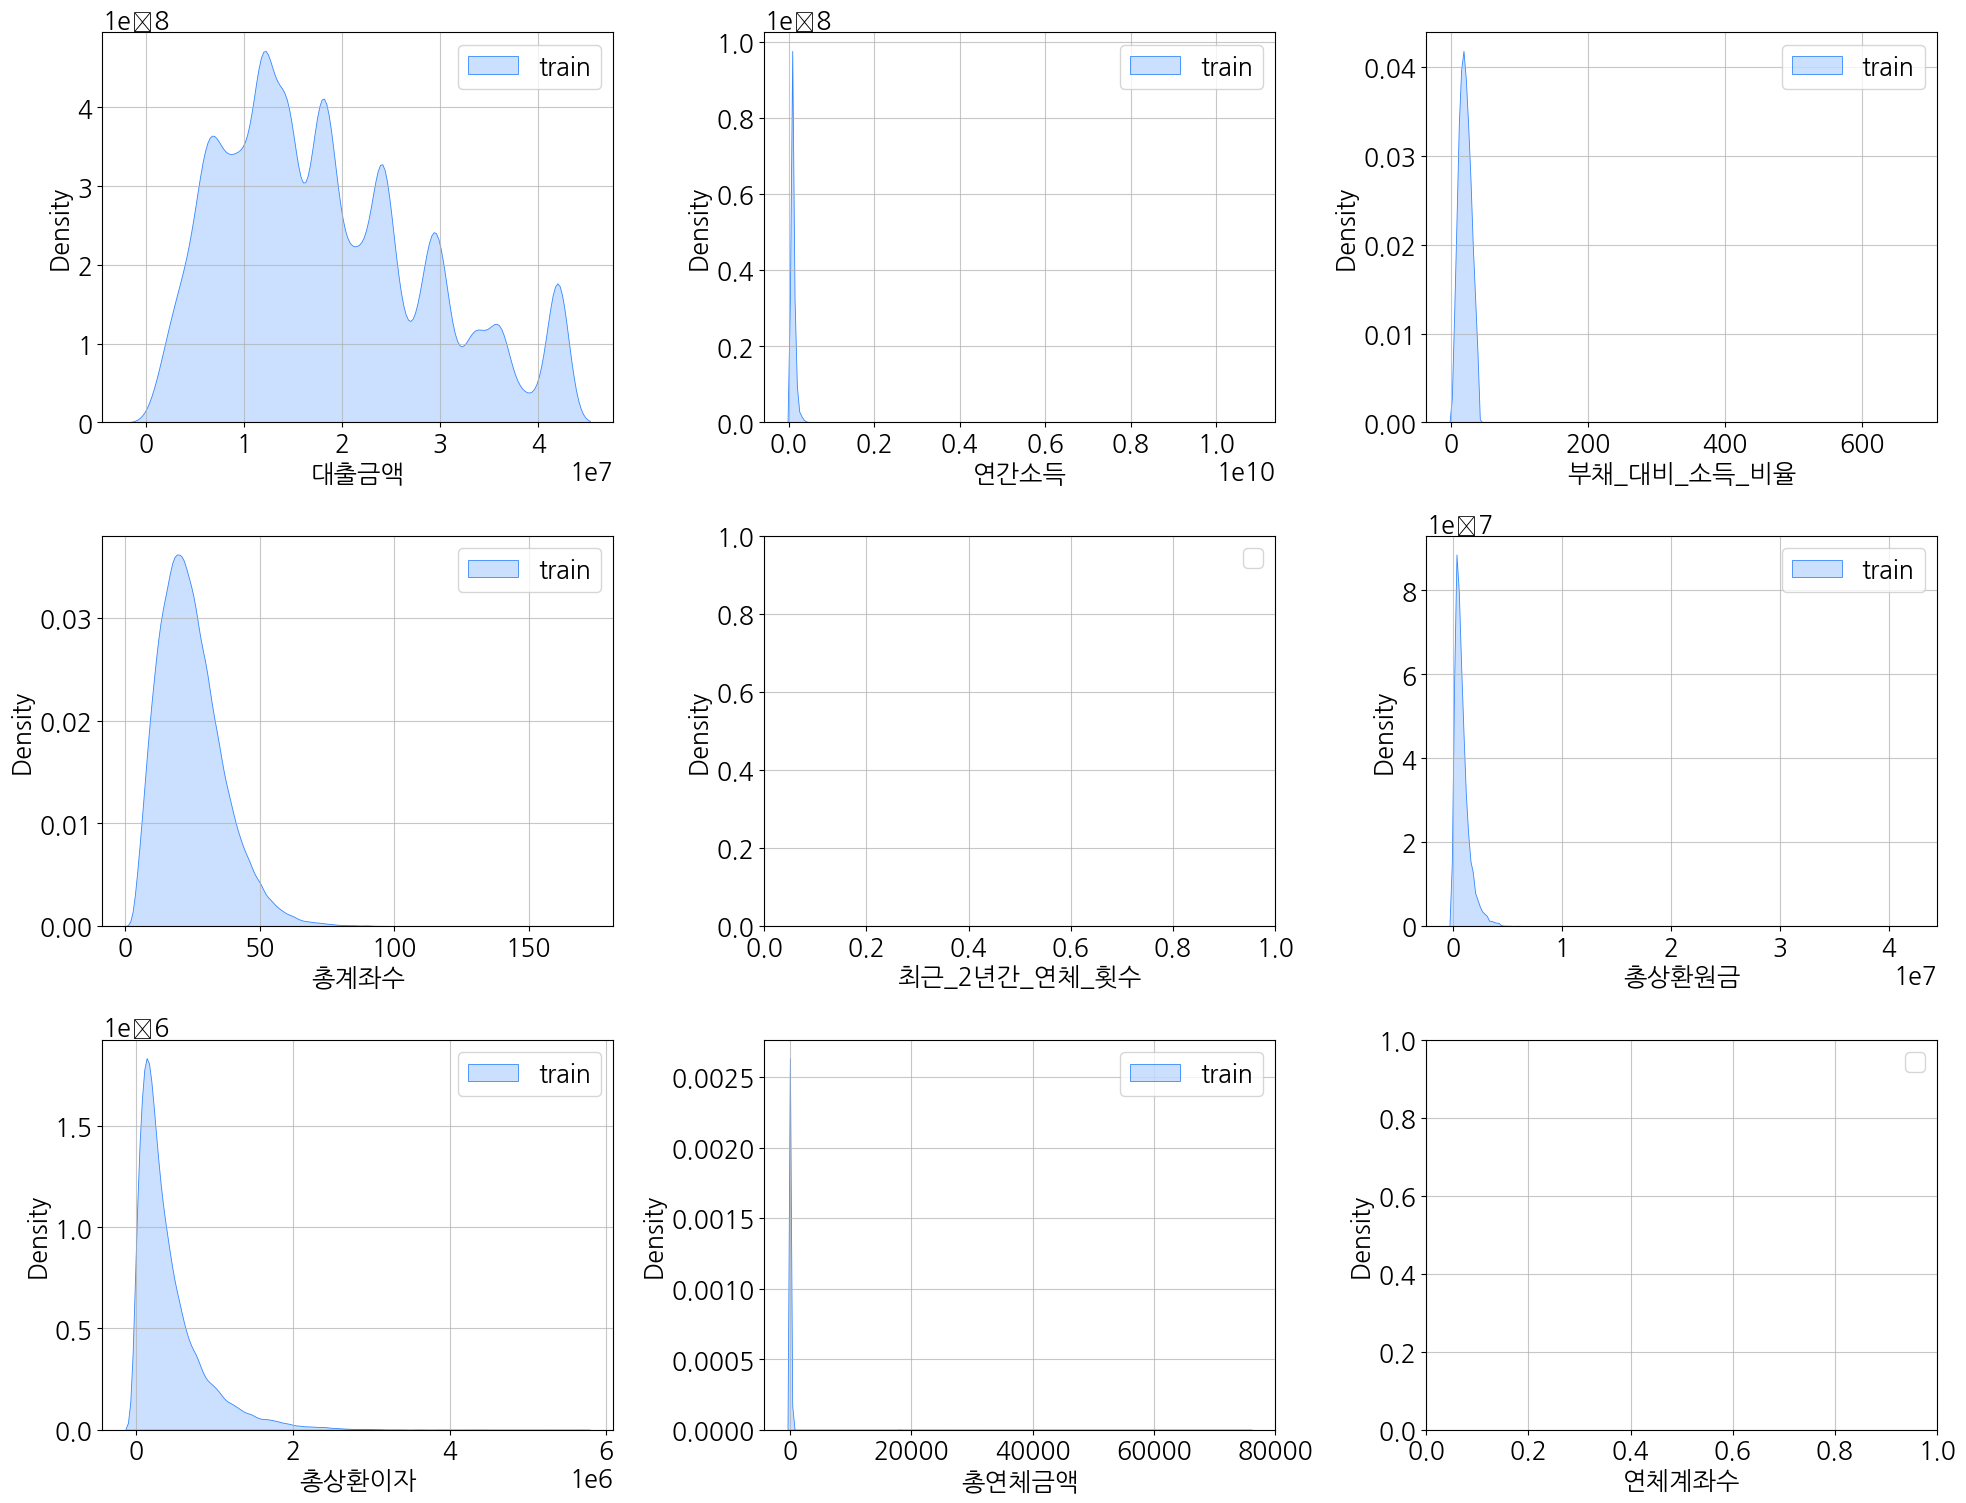

In [8]:
numeric_columns = train_0.drop(columns=['대출기간','근로기간','주택소유상태','대출목적','대출등급']).select_dtypes(include='number')

fig = plt.figure(figsize=(20, 50))
rows, cols = 10, 3
for idx, num in enumerate(numeric_columns[:30]):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.grid(alpha = 0.7, axis ="both")
    sns.kdeplot(x = num, fill = True,color ="#3386FF",linewidth=0.6, data = train_0, label = "train")
    ax.set_xlabel(num)
    ax.legend()
fig.tight_layout()
fig.show()

In [11]:
from collections import Counter
def detect_outliers(df,n,features):
    outlier_indices = []

    # iterating over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determining a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # appending the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # selecting observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

In [12]:
# detecting outliers
numeric_columns = train.drop(columns=['ID','대출등급']).select_dtypes(include='number')
ior = detect_outliers(train,0,numeric_columns)#,

In [13]:
train_out = train.drop(ior, axis = 0).reset_index(drop=True)
out_n0 = train.loc[train.index[ior]]

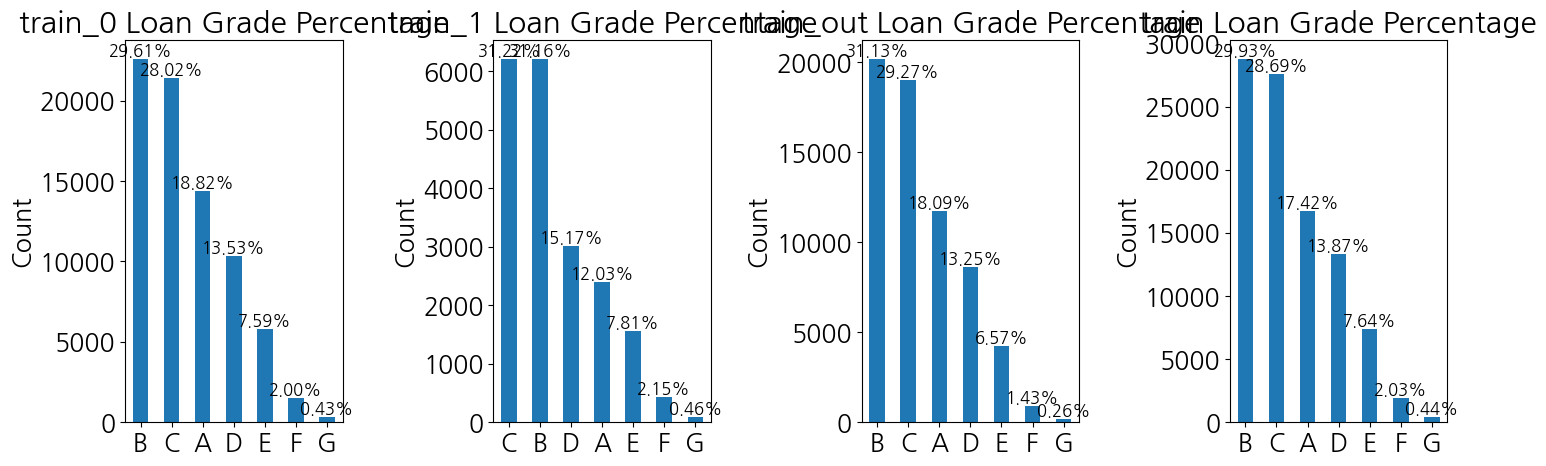

In [18]:
import matplotlib.pyplot as plt

def plot_loan_grade_percentage(df, title, ax):
    value_counts = df['대출등급'].value_counts()
    value_counts.plot(kind='bar', ax=ax, title=title)

    total = len(df)
    for i, value in enumerate(value_counts):
        ax.text(i, value, f'{(value/total)*100:.2f}%', ha='center', va='bottom', fontsize=12)

    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation='horizontal')
    ax.set_ylabel('Count')

# List of DataFrames and corresponding titles
dfs = [train_0, train_1, train_out,train]
titles = ['train_0 Loan Grade Percentage', 'train_1 Loan Grade Percentage', 'train_out Loan Grade Percentage','train Loan Grade Percentage']

# Create a single row with three subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Loop through DataFrames, titles, and subplots for plotting
for df, title, ax in zip(dfs, titles, axes):
    plot_loan_grade_percentage(df, title, ax)

plt.tight_layout()
plt.show()

# A,B,C / D,E / F,G

In [19]:
#no scaling
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96293 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96293 non-null  object 
 1   대출금액          96293 non-null  int64  
 2   대출기간          96293 non-null  object 
 3   근로기간          96293 non-null  object 
 4   주택소유상태        96293 non-null  object 
 5   연간소득          96293 non-null  int64  
 6   부채_대비_소득_비율   96293 non-null  float64
 7   총계좌수          96293 non-null  int64  
 8   대출목적          96293 non-null  object 
 9   최근_2년간_연체_횟수  96293 non-null  int64  
 10  총상환원금         96293 non-null  int64  
 11  총상환이자         96293 non-null  float64
 12  총연체금액         96293 non-null  float64
 13  연체계좌수         96293 non-null  float64
 14  대출등급          96293 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 13.8+ MB


In [20]:
new = train.copy()

In [22]:
def map_loan_grade(대출등급):
    if 대출등급 in ['A', 'B', 'C']:
        return 0
    elif 대출등급 in ['D', 'E']:
        return 1
    elif 대출등급 in ['F', 'G']:
        return 2
    else:
        return None

In [23]:
new['new'] = new['대출등급'].apply(map_loan_grade)

In [63]:
from sklearn.preprocessing import LabelEncoder
ordinal_features = ['대출기간', '근로기간', '주택소유상태','대출목적']

for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(new[feature])
    new[feature] = le.transform(new[feature])

In [30]:
new.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,new
0,TRAIN_00000,12480000,0,6,2,72000000,18.90,15,1,0,0,0.0,0.0,0.0,C,0
1,TRAIN_00001,14400000,1,1,0,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0,B,0
2,TRAIN_00002,12000000,0,5,0,96000000,8.60,14,1,0,928644,151944.0,0.0,0.0,A,0
3,TRAIN_00003,14400000,0,8,0,132000000,15.09,15,1,0,325824,153108.0,0.0,0.0,C,0
4,TRAIN_00004,18000000,1,11,2,71736000,25.39,19,8,0,228540,148956.0,0.0,0.0,B,0


In [28]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [31]:
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [34]:
from sklearn.model_selection import train_test_split
X = new.drop(['ID','대출등급','new'], axis=1)
y = new['new']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [35]:
# columns_to_scale = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
# X_test_scaled = scaler.transform(X_test[columns_to_scale])

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
print(f'XGBoost Cross-Validation F1 Macro: {xgb_scores.mean()}')

# Neural Network
nn_model = MLPClassifier(random_state=42)
nn_model.fit(X_train, y_train)
nn_predictions = nn_model.predict(X_test)
nn_scores = cross_val_score(nn_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
print(f'Neural Network Cross-Validation F1 Macro: {nn_scores.mean()}')

# CatBoost
cat_model = CatBoostClassifier(random_state=42, verbose=False)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
print(f'CatBoost Cross-Validation F1 Macro: {cat_scores.mean()}')

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
print(f'Random Forest Cross-Validation F1 Macro: {rf_scores.mean()}')

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
print(f'LightGBM Cross-Validation F1 Macro: {lgb_scores.mean()}')


XGBoost Cross-Validation F1 Macro: 0.8944653706075201
Neural Network Cross-Validation F1 Macro: 0.5927331811894657
CatBoost Cross-Validation F1 Macro: 0.8882456744008934
Random Forest Cross-Validation F1 Macro: 0.8169836428193136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1452
[LightGBM] [Info] Number of data points in the train set: 67405, number of used features: 13
[LightGBM] [Info] Start training from score -0.274043
[LightGBM] [Info] Start training from score -1.536915
[LightGBM] [Info] Start training from score -3.702698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

In [37]:
cat_predictions_flat = np.ravel(cat_predictions)

In [38]:
data = {
    'xgb': xgb_predictions,
    'cat': cat_predictions_flat,
    'lgb': lgb_predictions,
    'sol': y_test

}

pred_scale = pd.DataFrame(data)

In [39]:
pred_scale

,xgb,cat,lgb,sol
66217,0,0,0,0
34256,1,1,1,1
77556,0,0,0,0
64387,1,1,1,1
27485,1,1,1,1
...,...,...,...,...
63065,0,0,0,0
55298,1,1,1,1
49997,1,1,1,1
5647,0,0,0,0


In [41]:
abc = pred_scale[pred_scale['xgb']==0]

In [47]:
train_abc = new.loc[abc.index]

In [50]:
train_abc.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,new
66217,TRAIN_66217,15360000,1,6,2,48000000,21.30,20,1,0,536484,518736.0,2400.0,0.0,C,0
77556,TRAIN_77556,21600000,0,6,0,66000000,20.25,34,3,0,2094192,681324.0,0.0,0.0,B,0
38826,TRAIN_38826,10980000,0,1,1,31200000,17.91,18,3,0,516252,200796.0,0.0,0.0,B,0
96273,TRAIN_96273,33600000,0,2,0,222000000,17.43,49,3,0,1706676,333360.0,0.0,0.0,A,0
26471,TRAIN_26471,18000000,0,3,0,118800000,8.12,5,1,0,825240,364524.0,0.0,0.0,C,0


In [51]:
train_abc['대출등급'].value_counts()

B    8631
C    7954
A    5031
D     467
E     100
F      26
G       2
Name: 대출등급, dtype: int64

In [55]:
xgb_predictions = xgb_model.predict(x_tr)
# xgb_scores = cross_val_score(xgb_model, x_tr, y_tr, cv=StratifiedKFold(), scoring='f1_macro')
# print(f'XGBoost Cross-Validation F1 Macro: {xgb_scores.mean()}')

XGBoost Cross-Validation F1 Macro: 0.8944653706075201


In [ ]:
x_tr = train_abc.drop(['ID','new','대출등급'],axis=1)
y_tr = train_abc['대출등급']
xgb_model.fit(x_tr, y_tr)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
print(f'XGBoost Cross-Validation F1 Macro: {xgb_scores.mean()}')

In [60]:
new = train.copy()
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96293 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96293 non-null  object 
 1   대출금액          96293 non-null  int64  
 2   대출기간          96293 non-null  object 
 3   근로기간          96293 non-null  object 
 4   주택소유상태        96293 non-null  object 
 5   연간소득          96293 non-null  int64  
 6   부채_대비_소득_비율   96293 non-null  float64
 7   총계좌수          96293 non-null  int64  
 8   대출목적          96293 non-null  object 
 9   최근_2년간_연체_횟수  96293 non-null  int64  
 10  총상환원금         96293 non-null  int64  
 11  총상환이자         96293 non-null  float64
 12  총연체금액         96293 non-null  float64
 13  연체계좌수         96293 non-null  float64
 14  대출등급          96293 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 13.8+ MB


In [61]:
def map_loan_rating_category(grade):
    if grade in ['A', 'B', 'C']:
        return 0
    elif grade in ['D', 'E']:
        return 1
    elif grade in ['F', 'G']:
        return 2
    else:
        return None  # You can handle other cases if needed

# Apply the mapping function to create the new column 'Loan Category'
new['Loan Category'] = new['대출등급'].apply(map_loan_rating_category)

In [64]:
new.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,Loan Category
0,TRAIN_00000,12480000,0,6,2,72000000,18.90,15,1,0,0,0.0,0.0,0.0,C,0
1,TRAIN_00001,14400000,1,1,0,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0,B,0
2,TRAIN_00002,12000000,0,5,0,96000000,8.60,14,1,0,928644,151944.0,0.0,0.0,A,0
3,TRAIN_00003,14400000,0,8,0,132000000,15.09,15,1,0,325824,153108.0,0.0,0.0,C,0
4,TRAIN_00004,18000000,1,11,2,71736000,25.39,19,8,0,228540,148956.0,0.0,0.0,B,0


In [68]:
X = new.drop(['ID','대출등급', 'Loan Category'], axis=1)
y = new['Loan Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [69]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
print(f'XGBoost Cross-Validation F1 Macro: {xgb_scores.mean()}')

XGBoost Cross-Validation F1 Macro: 0.8970426588553255


In [71]:
from sklearn.metrics import classification_report
print("Classification Report for Loan Category:")
print(classification_report(y_test, xgb_predictions))

Classification Report for Loan Category:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22023
           1       0.92      0.89      0.91      6135
           2       0.89      0.77      0.83       730

    accuracy                           0.96     28888
   macro avg       0.93      0.88      0.90     28888
weighted avg       0.96      0.96      0.96     28888



In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96293 entries, 0 to 96293
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     96293 non-null  object 
 1   대출금액                   96293 non-null  int64  
 2   대출기간                   96293 non-null  object 
 3   근로기간                   96293 non-null  object 
 4   주택소유상태                 96293 non-null  object 
 5   연간소득                   96293 non-null  int64  
 6   부채_대비_소득_비율            96293 non-null  float64
 7   총계좌수                   96293 non-null  int64  
 8   대출목적                   96293 non-null  object 
 9   최근_2년간_연체_횟수           96293 non-null  int64  
 10  총상환원금                  96293 non-null  int64  
 11  총상환이자                  96293 non-null  float64
 12  총연체금액                  96293 non-null  float64
 13  연체계좌수                  96293 non-null  float64
 14  대출등급                   96293 non-null  object 
 15  Pr

In [82]:
new2 = train.copy()

In [83]:
from sklearn.preprocessing import LabelEncoder
ordinal_features = ['대출기간', '근로기간', '주택소유상태','대출목적']

for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(new2[feature])
    new2[feature] = le.transform(new2[feature])

In [84]:
def map_loan_rating_category(grade):
    if grade in ['A', 'B', 'C','D','E']:
        return 0
    elif grade in ['F', 'G']:
        return 1
    else:
        return None  # You can handle other cases if needed

# Apply the mapping function to create the new column 'Loan Category'
new2['Loan Category'] = new2['대출등급'].apply(map_loan_rating_category)

In [85]:
new2.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,Loan Category
0,TRAIN_00000,12480000,0,6,2,72000000,18.90,15,1,0,0,0.0,0.0,0.0,C,0
1,TRAIN_00001,14400000,1,1,0,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0,B,0
2,TRAIN_00002,12000000,0,5,0,96000000,8.60,14,1,0,928644,151944.0,0.0,0.0,A,0
3,TRAIN_00003,14400000,0,8,0,132000000,15.09,15,1,0,325824,153108.0,0.0,0.0,C,0
4,TRAIN_00004,18000000,1,11,2,71736000,25.39,19,8,0,228540,148956.0,0.0,0.0,B,0


In [86]:
X = new2.drop(['ID','대출등급', 'Loan Category'], axis=1)
y = new2['Loan Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [87]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
print(f'XGBoost Cross-Validation F1 Macro: {xgb_scores.mean()}')

XGBoost Cross-Validation F1 Macro: 0.8982068127536904


In [88]:
from sklearn.metrics import classification_report
print("Classification Report for Loan Category:")
print(classification_report(y_test, xgb_predictions))

Classification Report for Loan Category:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     28158
           1       0.88      0.76      0.82       730

    accuracy                           0.99     28888
   macro avg       0.94      0.88      0.91     28888
weighted avg       0.99      0.99      0.99     28888

